In [1]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [2]:
from malaya_speech.train.model import aligner, fastvc, fastspeech
import malaya_speech
import tensorflow as tf
import matplotlib.pyplot as plt






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
from scipy.stats import betabinom
import numpy as np

def beta_binomial_prior_distribution(phoneme_count, mel_count, scaling_factor=1.0):
    x = np.arange(0, phoneme_count)
    mel_text_probs = []
    for i in range(1, mel_count + 1):
        a, b = scaling_factor * i, scaling_factor * (mel_count + 1 - i)
        mel_i_prob = betabinom(phoneme_count, a, b).pmf(x)
        mel_text_probs.append(mel_i_prob)
    return np.array(mel_text_probs)

attn_prior = np.expand_dims(beta_binomial_prior_distribution(50, 100), 0).astype(np.float32)
attn_prior.shape, attn_prior.min(), attn_prior.max()

((1, 100, 50), 4.968e-41, 0.6666667)

In [4]:
i = tf.placeholder(tf.int32, [None, None])
lens = tf.placeholder(tf.int32, [None])
mel = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
prior = tf.placeholder(tf.float32, [None, None, None])

In [5]:
config = malaya_speech.config.fastspeech_config
config = fastspeech.Config(vocab_size = 1, **config)

In [6]:
encoder_mel = fastvc.Decoder(config.decoder_self_attention_params, use_position_embedding=True)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
max_length = tf.cast(tf.reduce_max(mel_lengths), tf.int32)
attention_mask = tf.sequence_mask(
    lengths=mel_lengths, maxlen=max_length, dtype=tf.float32
)
attention_mask.set_shape((None, None))

In [8]:
denser = tf.keras.layers.Dense(
    units=config.decoder_self_attention_params.hidden_size, dtype=tf.float32, 
    name='mel_before'
)

In [9]:
mel_ = encoder_mel(denser(mel), attention_mask)
mel_

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


<tf.Tensor 'Decoder/encoder/layer_._3/mul:0' shape=(?, ?, 384) dtype=float32>

In [10]:
encoder = aligner.AlignmentEncoder(vocab_size = 100, vocab_embedding = 512)

In [11]:
attention_mask = tf.expand_dims(tf.math.not_equal(i, 0), -1)
attention_mask

<tf.Tensor 'ExpandDims:0' shape=(?, ?, 1) dtype=bool>

In [12]:
attn_soft, attn_logprob = encoder(mel_, i, mask = attention_mask, attn_prior = prior)
attn_soft, attn_logprob

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'AlignmentEncoder/Softmax:0' shape=(?, 1, ?, ?) dtype=float32>,
 <tf.Tensor 'AlignmentEncoder/Identity:0' shape=(?, 1, ?, ?) dtype=float32>)

In [13]:
attn_hard = encoder.get_hard_attention(attn_soft, lens, mel_lengths)
attn_hard

<tf.Tensor 'PyFunc:0' shape=(?, 1, ?, ?) dtype=float32>

In [14]:
forwardsum_loss = aligner.forwardsum_loss(attn_logprob, lens, mel_lengths)
forwardsum_loss

Instructions for updating:
Use `tf.cast` instead.



<tf.Tensor 'truediv:0' shape=() dtype=float32>

In [15]:
bin_loss = aligner.bin_loss(attn_hard, attn_soft)
bin_loss

<tf.Tensor 'truediv_1:0' shape=() dtype=float32>

In [16]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-5).minimize(forwardsum_loss + bin_loss)

In [17]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [18]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)

In [19]:
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [20]:
l_text = data['len_text_ids'][0,0]
l_mel = data['len_mel'][0,0]
l_text, l_mel

(72, 408)

In [21]:
prior_ = np.expand_dims(beta_binomial_prior_distribution(l_text, l_mel), 0).astype(np.float32)
prior_.shape

(1, 408, 72)

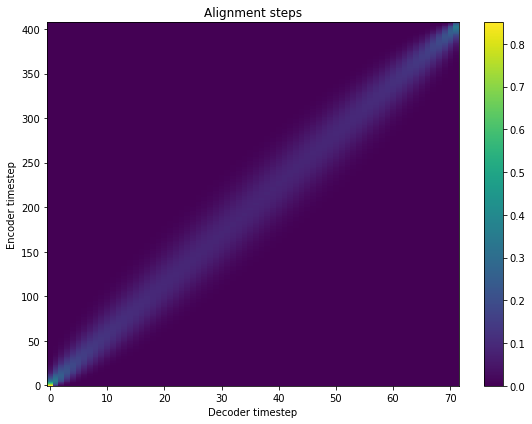

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    prior_[0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [23]:
o = sess.run([attn_soft, attn_logprob], feed_dict = {i: data['text_ids'],
                                                    lens: data['len_text_ids'][:,0],
                                                    mel: data['mel'],
                                                    mel_lengths: data['len_mel'][:,0],
                                                    prior: prior_})
o[0].shape, o[1].shape

((1, 1, 408, 72), (1, 1, 408, 72))

In [24]:
for no in range(200):
    o = sess.run([forwardsum_loss, bin_loss, optimizer], feed_dict = {i: data['text_ids'],
                                                        lens: data['len_text_ids'][:,0],
                                                        mel: data['mel'],
                                                        mel_lengths: data['len_mel'][:,0],
                                                        prior: prior_})
    print(no, o)

/Users/huseinzolkepli/Documents/malaya-speech/malaya_speech/train/model/aligner/model.py:20: RuntimeWarning: divide by zero encountered in log
  attn_map = np.log(attn_map)


0 [2063.7295, 2.2989476, None]
1 [2063.5732, 2.2988272, None]
2 [2063.388, 2.2987154, None]
3 [2063.2424, 2.2986178, None]
4 [2063.0662, 2.2985396, None]
5 [2062.92, 2.29842, None]
6 [2062.7432, 2.2983565, None]
7 [2062.557, 2.2982357, None]
8 [2062.371, 2.2981472, None]
9 [2062.1519, 2.2980292, None]
10 [2061.9534, 2.2979302, None]
11 [2061.7405, 2.297872, None]
12 [2061.485, 2.2977533, None]
13 [2061.2488, 2.2976723, None]
14 [2060.9517, 2.297545, None]
15 [2060.6755, 2.2974513, None]
16 [2060.3264, 2.2973192, None]
17 [2059.999, 2.2972298, None]
18 [2059.6572, 2.2971327, None]
19 [2059.2659, 2.2969692, None]
20 [2058.9, 2.2969368, None]
21 [2058.4873, 2.296794, None]
22 [2058.0537, 2.2967227, None]
23 [2057.5593, 2.2965581, None]
24 [2057.0737, 2.2964816, None]
25 [2056.5686, 2.2963445, None]
26 [2056.041, 2.2962317, None]
27 [2055.4905, 2.296157, None]
28 [2054.8994, 2.2960818, None]
29 [2054.2937, 2.2959194, None]
30 [2053.6787, 2.2957838, None]
31 [2053.0125, 2.2957227, None]
32 

In [25]:
o = sess.run([attn_soft, attn_logprob, attn_hard], feed_dict = {i: data['text_ids'],
                                                    lens: data['len_text_ids'][:,0],
                                                    mel: data['mel'],
                                                    mel_lengths: data['len_mel'][:,0],
                                                    prior: prior_})
o[0].shape, o[1].shape, o[2].shape

((1, 1, 408, 72), (1, 1, 408, 72), (1, 1, 408, 72))

In [26]:
o[0][0,0].shape

(408, 72)

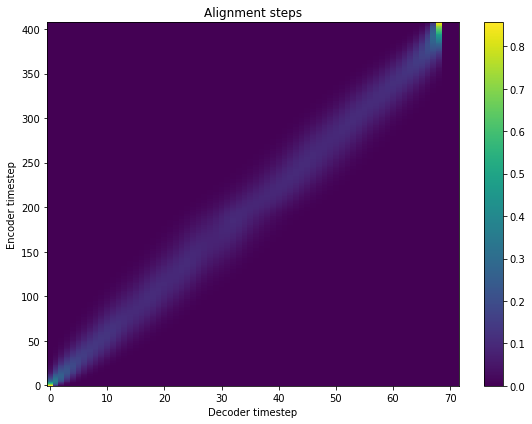

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[0][0,0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

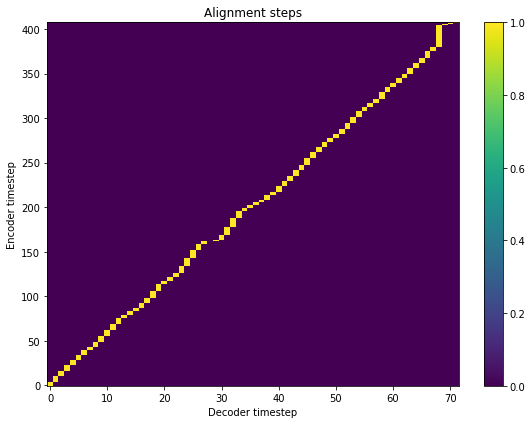

In [28]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[2][0,0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [29]:
tf.trainable_variables()

[<tf.Variable 'mel_before/kernel:0' shape=(80, 384) dtype=float32>,
 <tf.Variable 'mel_before/bias:0' shape=(384,) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/self/query/kernel:0' shape=(384, 384) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/self/query/bias:0' shape=(384,) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/self/key/kernel:0' shape=(384, 384) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/self/key/bias:0' shape=(384,) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/self/value/kernel:0' shape=(384, 384) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/self/value/bias:0' shape=(384,) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/output/dense/kernel:0' shape=(384, 384) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/output/dense/bias:0' shape=(384,) dtype=float32>,
 <tf.Variable 'Decoder/encoder/layer_._0/attention/ou

In [30]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'

In [31]:
!ls -lh test
!rm -rf test

total 139712
-rw-r--r--  1 huseinzolkepli  staff    77B Sep 23 21:14 checkpoint
-rw-r--r--  1 huseinzolkepli  staff    52M Sep 23 21:14 model.ckpt.data-00000-of-00001
-rw-r--r--  1 huseinzolkepli  staff   3.2K Sep 23 21:14 model.ckpt.index
-rw-r--r--  1 huseinzolkepli  staff    16M Sep 23 21:14 model.ckpt.meta
